**Pytorch一般有以下几个流程**


### 1.数据读取

### 2.数据处理

### 3.搭建网络

### 4.模型训练

### 5.模型上线

### 1.数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
torch.__version__

'1.8.1+cu101'

In [2]:
# import tensorflow as tf
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # 忽略低级别的警告
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8
# # config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [3]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),

    transforms.RandomCrop(32,padding=4), # 数据增广
    transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [4]:
Batch_Size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. 查看数据（格式，大小，形状）

In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [9]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    
 ### 3. 查看图片

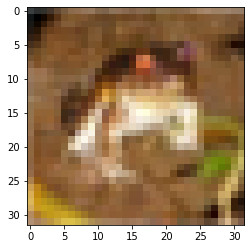

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

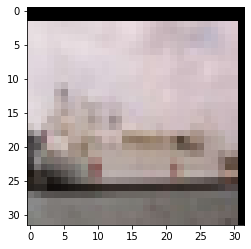

In [12]:
imshow(im[0])

In [13]:
im[0].shape

torch.Size([3, 32, 32])

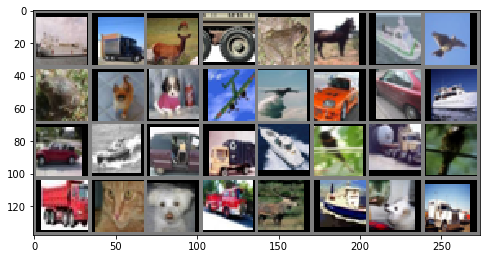

In [14]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

### 4.定义网络（ResNet）

当大家还在惊叹 GoogLeNet 的 inception 结构的时候，微软亚洲研究院的研究员已经在设计更深但结构更加简单的网络 ResNet，并且凭借这个网络斩获当年ImageNet竞赛中分类任务第一名，目标检测第一名。获得COCO数据集中目标检测第一名，图像分割第一名。

如果想详细了解并查看论文，可以看我的另一篇博客[【论文泛读】 ResNet：深度残差网络](https://blog.csdn.net/weixin_45508265/article/details/119069665)

下图是ResNet18层模型的结构简图

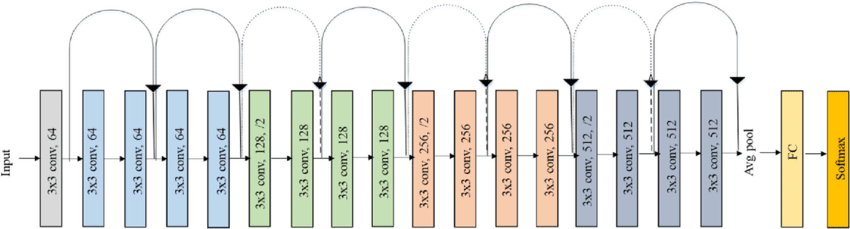

还有ResNet-34模型
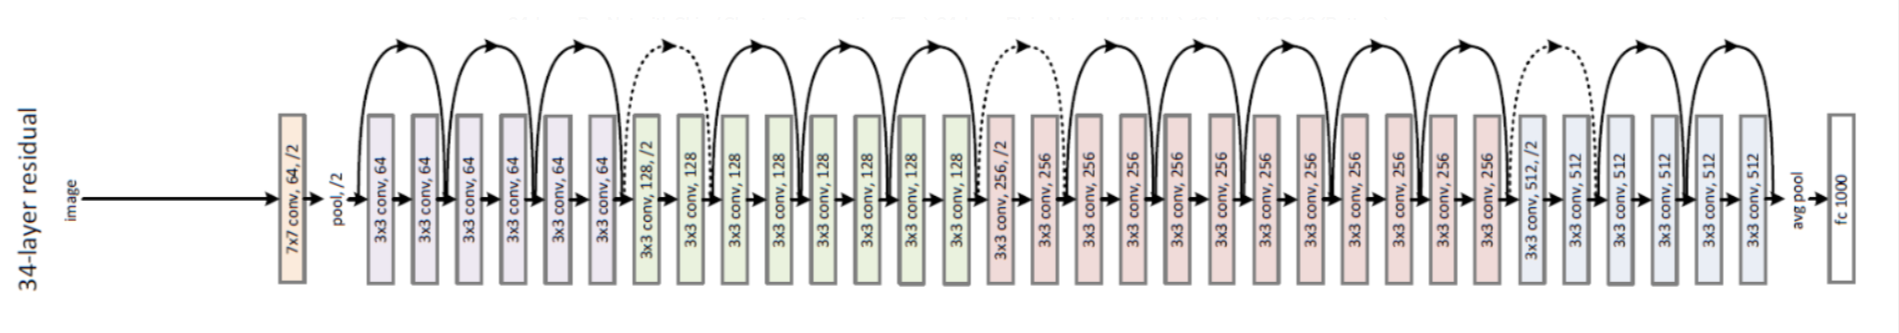

在ResNet网络中有如下几个亮点：

（1）提出residual结构（残差结构），并搭建超深的网络结构(突破1000层)

（2）使用Batch Normalization加速训练(丢弃dropout)

在ResNet网络提出之前，传统的卷积神经网络都是通过将一系列卷积层与下采样层进行堆叠得到的。但是当堆叠到一定网络深度时，就会出现两个问题。

（1）梯度消失或梯度爆炸。 

（2）退化问题(degradation problem)。

## 残差结构

在ResNet论文中说通过数据的预处理以及在网络中使用BN（Batch Normalization）层能够解决梯度消失或者梯度爆炸问题，residual结构（残差结构）来减轻退化问题。此时拟合目标就变为F(x)，F(x)就是残差
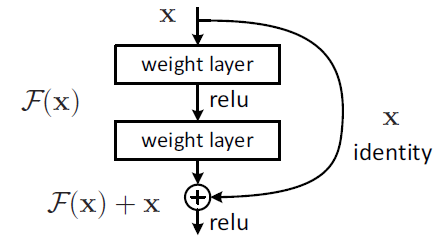

这里有一个点是很重要的，对于我们的第二个layer，它是没有relu激活函数的，他需要与x相加最后再进行激活函数relu

## ResNet18/34 的Residual结构

我们先对ResNet18/34的残差结构进行一个分析。如下图所示，该残差结构的主分支是由两层3x3的卷积层组成，而残差结构右侧的连接线是shortcut分支也称捷径分支（注意为了让主分支上的输出矩阵能够与我们捷径分支上的输出矩阵进行相加，**必须保证这两个输出特征矩阵有相同的shape**）。我们会发现有一些虚线结构，论文中表述为用1x1的卷积进行降维，下图给出了详细的残差结构。

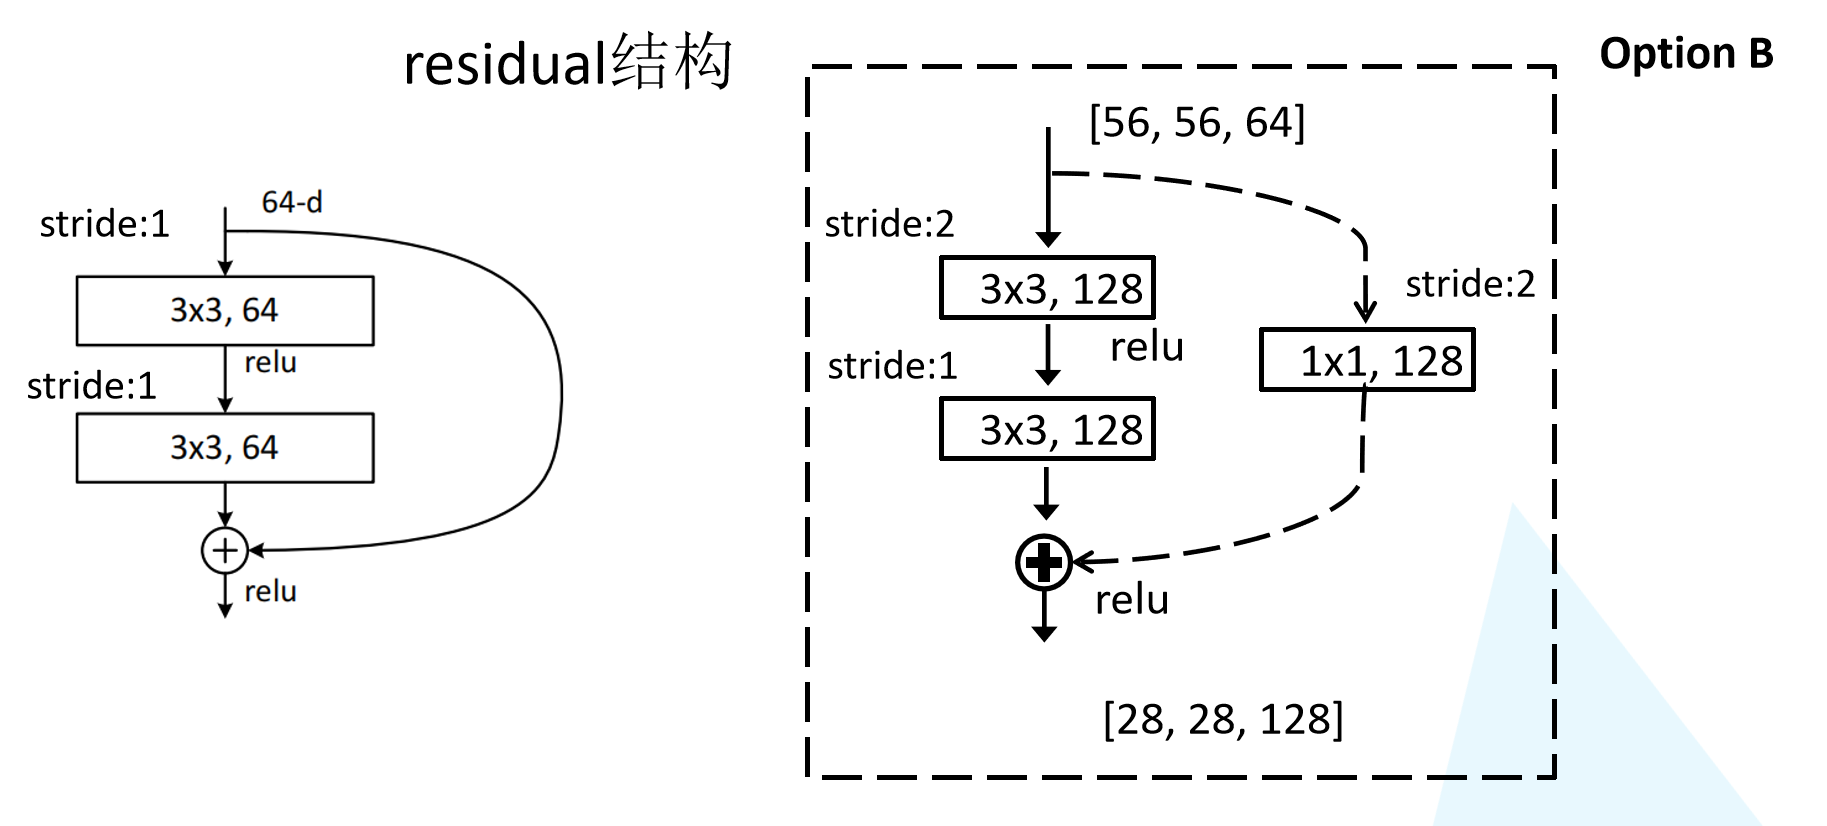


## ResNet50/101/152的Bottleneck结构

接着我们再来分析下针对ResNet50/101/152的残差结构，如下图所示。在该残差结构当中，主分支使用了三个卷积层，第一个是1x1的卷积层用来压缩channel维度，第二个是3x3的卷积层，第三个是1x1的卷积层用来还原channel维度（注意主分支上第一层卷积层和第二次卷积层所使用的卷积核个数是相同的，第三次是第一层的4倍），这种又叫做bottleneck模型
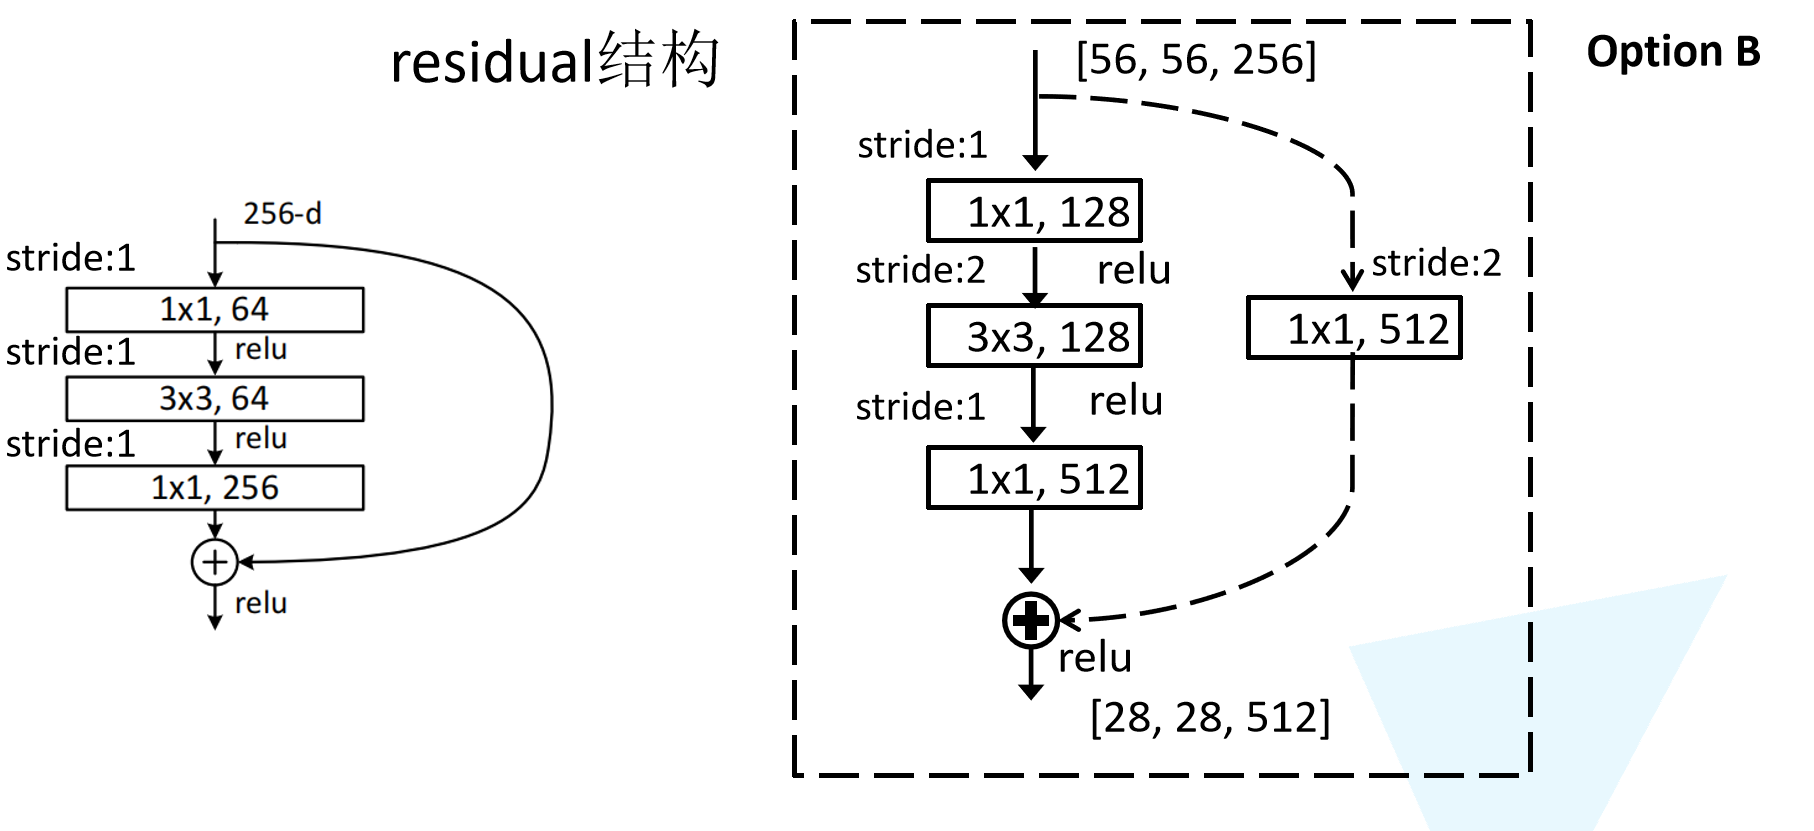

## ResNet网络结构配置

这是在ImageNet数据集中更深的残差网络的模型，这里面给出了残差结构给出了主分支上卷积核的大小与卷积核个数，表中的xN表示将该残差结构重复N次。

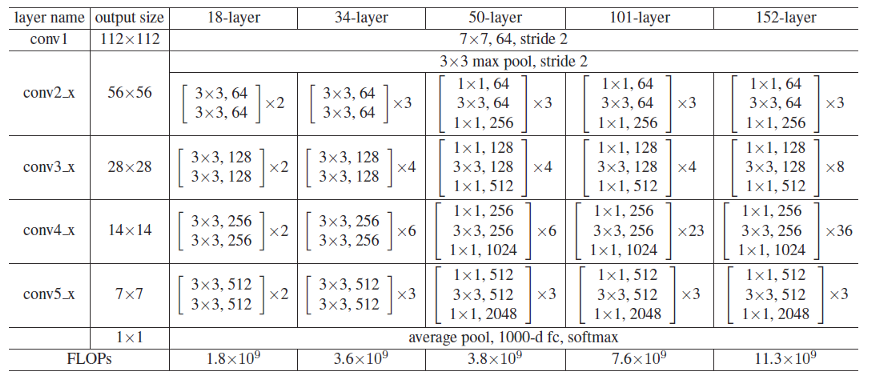

对于我们ResNet18/34/50/101/152，表中conv3_x, conv4_x, conv5_x所对应的一系列残差结构的第一层残差结构都是虚线残差结构。因为这一系列残差结构的第一层都有调整输入特征矩阵shape的使命（将特征矩阵的高和宽缩减为原来的一半，将深度channel调整成下一层残差结构所需要的channel）

- ResNet-50：我们用3层瓶颈块替换34层网络中的每一个2层块，得到了一个50层ResNe。我们使用1x1卷积核来增加维度。该模型有**38亿FLOP**。
- ResNet-101/152：我们通过使用更多的3层瓶颈块来构建101层和152层ResNets。值得注意的是，尽管深度显著增加，但152层ResNet（**113亿FLOP**）仍然比VGG-16/19网络（**153/196亿FLOP**）具有更低的复杂度。

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 判断是否用GPU
device

'cuda'

### BasicBlock

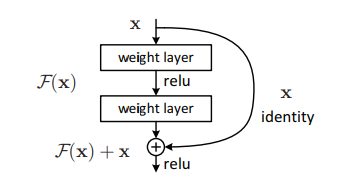

In [16]:
class BasicBlock(nn.Module):
    """
    对于浅层网络，如ResNet-18/34等，用基本的Block
    基础模块没有压缩,所以expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # 如果输入输出维度不等，则使用1x1卷积层来改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [17]:
# 测试
basic_block = BasicBlock(64, 128)
print(basic_block)
x = torch.randn(2, 64, 32, 32)
y = basic_block(x)
print(y.shape)

BasicBlock(
  (features): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 128, 32, 32])


### Bottleneck Block
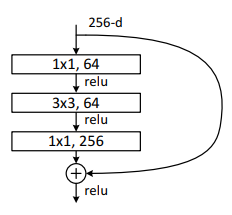

In [18]:
class Bottleneck(nn.Module):
    """
    对于深层网络，我们使用BottleNeck，论文中提出其拥有近似的计算复杂度，但能节省很多资源
    zip_channels: 压缩后的维数，最后输出的维数是 expansion * zip_channels
    针对ResNet50/101/152的网络结构,主要是因为第三层是第二层的4倍的关系所以expansion=4
    """
    expansion = 4
    
    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.features(x)
#         print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

In [19]:
# 测试
bottleneck = Bottleneck(256, 128)
print(bottleneck)
x = torch.randn(2, 256, 32, 32)
y = bottleneck(x)
print(y.shape)

Bottleneck(
  (features): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (shortcut): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([2, 512, 32, 32])


### ResNet
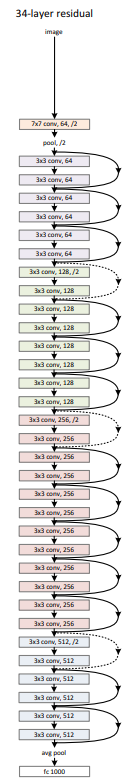

In [20]:
class ResNet(nn.Module):
    """
    不同的ResNet架构都是统一的一层特征提取、四层残差，不同点在于每层残差的深度。
    对于cifar10，feature map size的变化如下：
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2] 
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool] 
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #使用_make_layer函数生成上表对应的conv2_x, conv3_x, conv4_x, conv5_x的结构
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # cifar10经过上述结构后，到这里的feature map size是 4 x 4 x 512 x expansion
        # 所以这里用了 4 x 4 的平均池化
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 第一个block要进行降采样
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # 如果是Bottleneck Block的话需要对每层输入的维度进行压缩，压缩后再增加维数
            # 所以每层的输入维数也要跟着变
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)        
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [21]:
def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)

In [22]:
net = ResNet18(True).to(device)
print(net)

ResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (features): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [23]:
# 测试
x = torch.randn(2, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

block 1 output: torch.Size([2, 64, 32, 32])
block 2 output: torch.Size([2, 64, 32, 32])
block 3 output: torch.Size([2, 128, 16, 16])
block 4 output: torch.Size([2, 256, 8, 8])
block 5 output: torch.Size([2, 512, 4, 4])
torch.Size([2, 10])


In [24]:
net = ResNet50().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

### 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [25]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 20

### 6. 训练

In [26]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/ResNet50.pth'

文件已存在


In [27]:
from utils import train
from utils import plot_history
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

Epoch [  1/ 20]  Train Loss:2.482768  Train Acc:20.01% Test Loss:1.863306  Test Acc:29.53%  Learning Rate:0.100000	Time 06:35
Epoch [  2/ 20]  Train Loss:1.732180  Train Acc:35.05% Test Loss:1.596699  Test Acc:40.46%  Learning Rate:0.100000	Time 06:30
Epoch [  3/ 20]  Train Loss:1.450473  Train Acc:46.64% Test Loss:1.376813  Test Acc:50.43%  Learning Rate:0.100000	Time 06:37
Epoch [  4/ 20]  Train Loss:1.233495  Train Acc:55.75% Test Loss:1.179428  Test Acc:56.90%  Learning Rate:0.100000	Time 06:36
Epoch [  5/ 20]  Train Loss:1.096555  Train Acc:60.66% Test Loss:1.138862  Test Acc:59.58%  Learning Rate:0.100000	Time 06:34
Epoch [  6/ 20]  Train Loss:1.019888  Train Acc:63.56% Test Loss:1.174744  Test Acc:59.26%  Learning Rate:0.100000	Time 06:36
Epoch [  7/ 20]  Train Loss:0.954559  Train Acc:66.09% Test Loss:0.994502  Test Acc:64.81%  Learning Rate:0.100000	Time 06:35
Epoch [  8/ 20]  Train Loss:0.906867  Train Acc:67.94% Test Loss:0.954770  Test Acc:66.60%  Learning Rate:0.100000	Tim

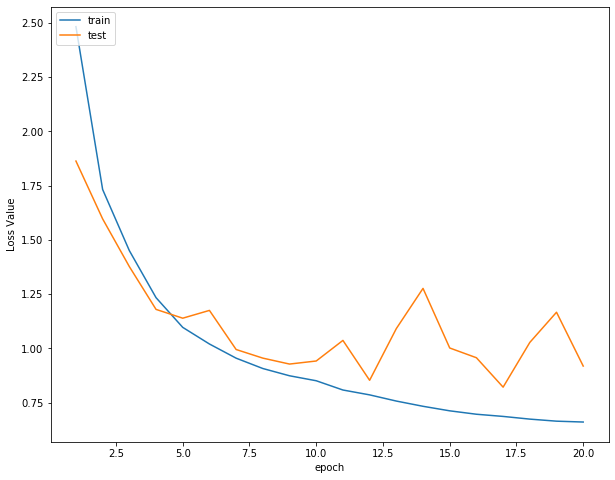

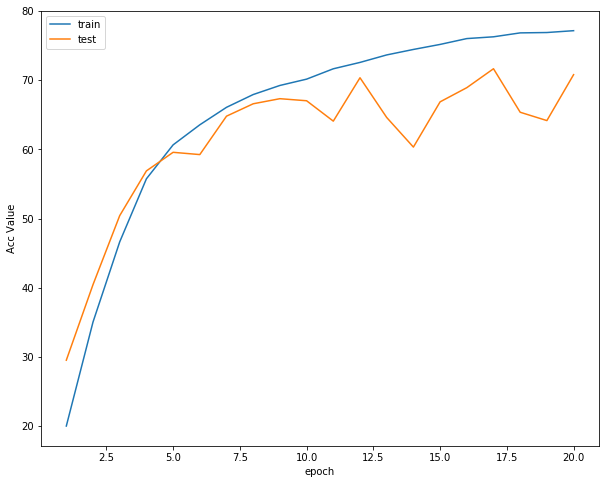

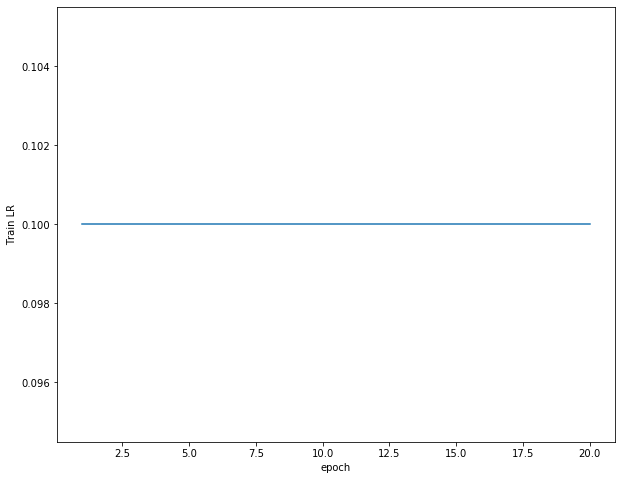

In [28]:
plot_history(epoch ,Acc, Loss, Lr)

### 7.测试

In [29]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
torch.cuda.empty_cache()
net.eval()
with torch.no_grad():
    for data in testloader:  # 循环每一个batch
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        net.eval()  # 把模型转为test模式
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)  # 输入网络进行测试

        # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)          # 更新测试图片的数量
        correct += (predicted == labels).sum() # 更新正确分类的图片的数量

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 70.67 %


In [30]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 85.60 %
Accuracy of automobile : 89.90 %
Accuracy of  bird : 43.20 %
Accuracy of   cat : 23.20 %
Accuracy of  deer : 74.90 %
Accuracy of   dog : 66.50 %
Accuracy of  frog : 96.40 %
Accuracy of horse : 63.20 %
Accuracy of  ship : 73.80 %
Accuracy of truck : 88.00 %


Accuracy Rate = 64.0625%


<Figure size 1800x288 with 0 Axes>

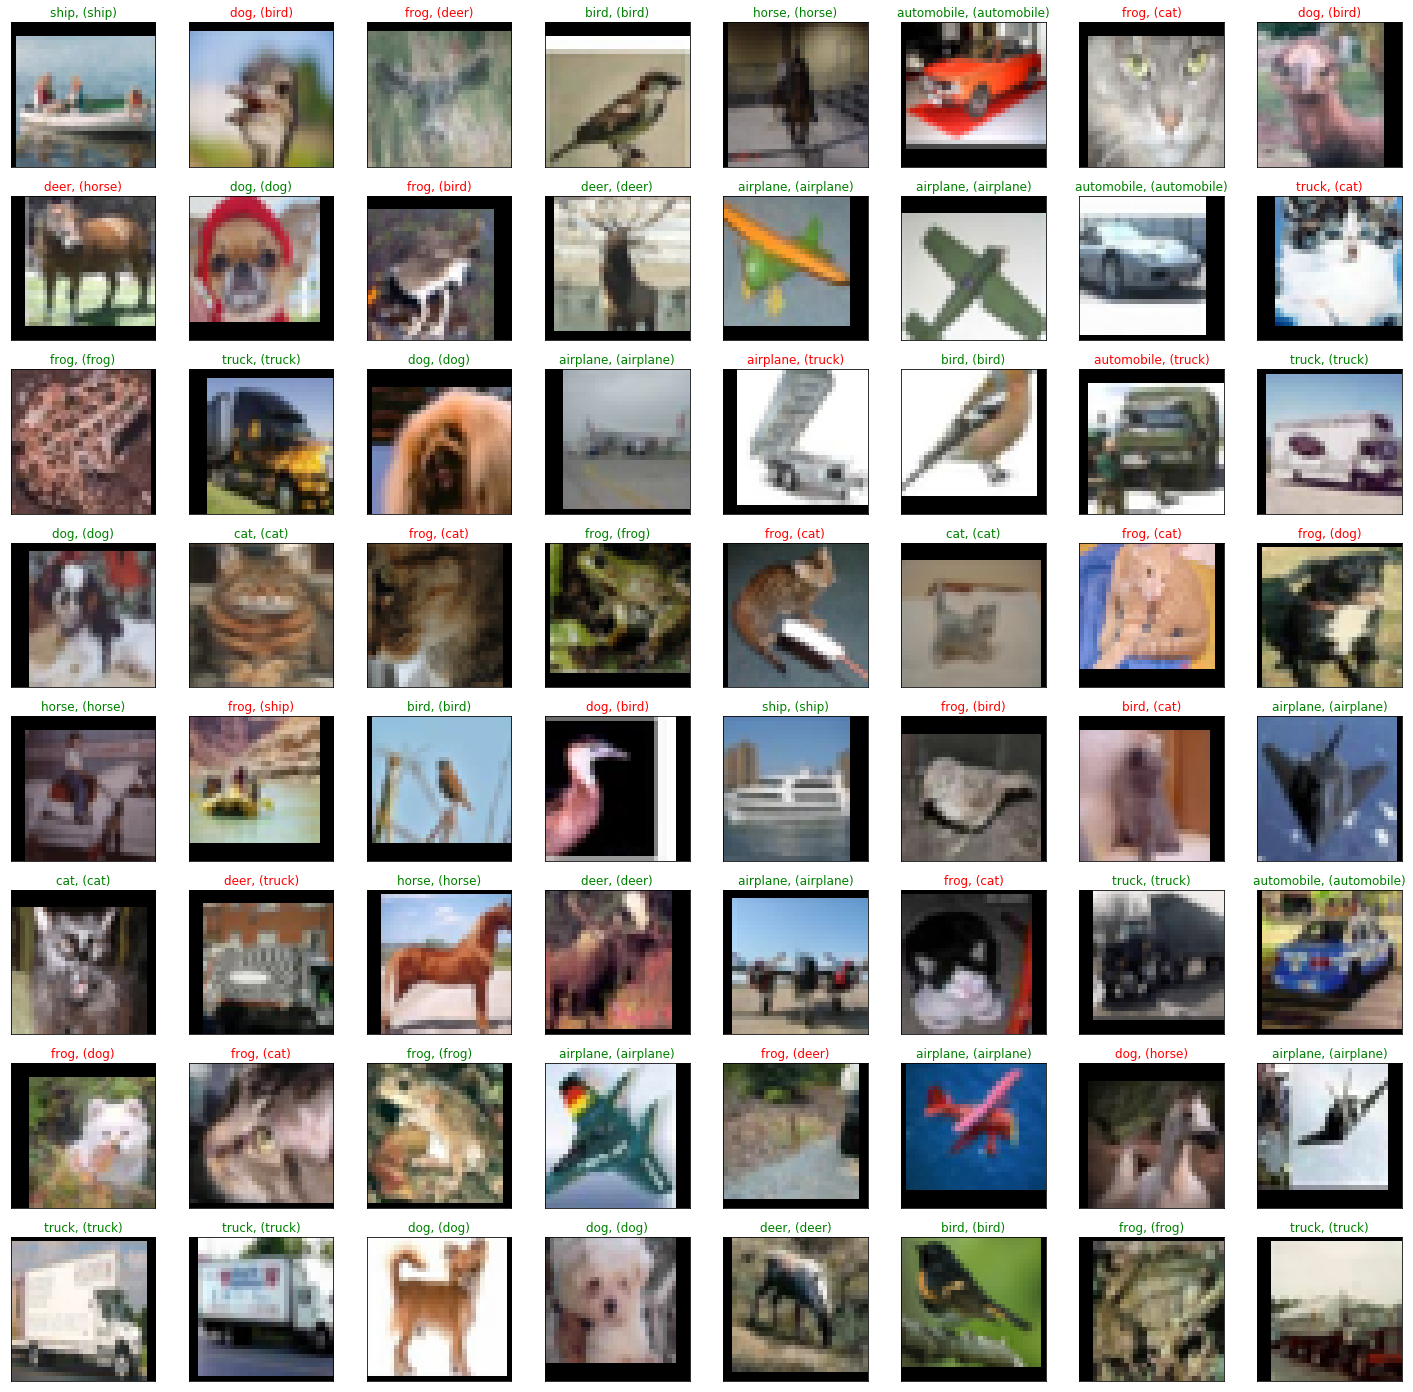

In [31]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

In [32]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')
# torch.save(net, './model/ResNet50.pth')

### 9. 预测

In [33]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet50()

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

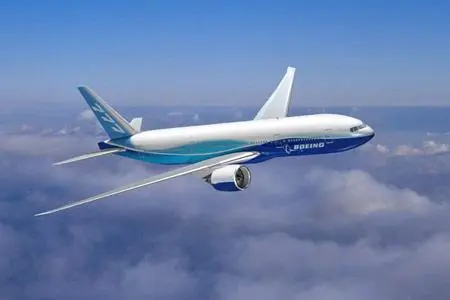

In [34]:
img

In [35]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


概率 tensor([[9.1440e-01, 5.8445e-05, 1.4419e-02, 1.1107e-04, 1.0165e-02, 2.0981e-05,
         6.9743e-05, 3.6756e-05, 6.0512e-02, 2.0208e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 0
tensor([6.8741], device='cuda:0')
分类 plane


<Response [200]>


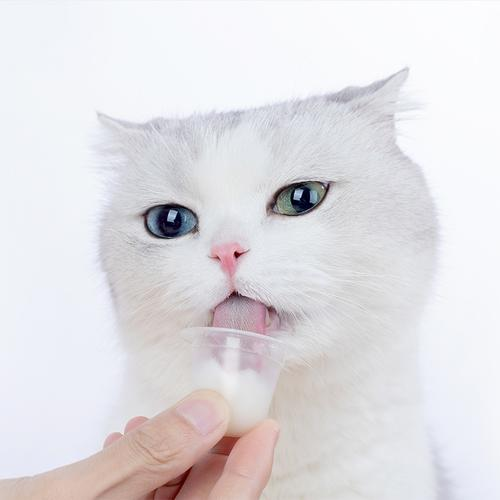

In [36]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [37]:
trans = transforms.Compose([transforms.Scale((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[0.1600, 0.0006, 0.3802, 0.1469, 0.1960, 0.0671, 0.0096, 0.0155, 0.0201,
         0.0041]], device='cuda:0', grad_fn=<SoftmaxBackward>)
类别 2
tensor([2.5009], device='cuda:0')
分类 bird


c:\users\86137\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
